# Hierarchical Beta‑Binomial Analysis
This notebook extends the previous exploratory analyses with a **hierarchical beta‑binomial Bayesian model** (via PyMC) for participants’ accuracy.

* First‑order trials → max 4 correct presses per trial  
* Second‑order trials → max 2 correct presses per trial  

Model (per order type):
```text
α, β            ~ HalfNormal(5)
θ_participant[i] ~ Beta(α, β)          # latent accuracy of participant i
k_i            ~ Binomial(n_i, θ_i)   # observed successes
```
We fit the model separately for first‑ and second‑order data, extract the posterior mean of each participant’s θ, and correlate those means with **worry** and **somatic anxiety**.


In [31]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import pymc as pm, arviz as az
from scipy.stats import pearsonr,spearmanr

sns.set(style='whitegrid'); plt.rcParams['figure.dpi']=120
FILE='game_trials_export.csv'
df=pd.read_csv(FILE)
df['correctness_generalization']=pd.to_numeric(df['correctness_generalization'], errors='coerce')
df['worry']=pd.to_numeric(df['worry'], errors='coerce')
df['somatic_anxiety']=pd.to_numeric(df['somatic_anxiety'], errors='coerce')
df.columns

Index(['phase', 'vehicle', 'startTime', 'moves', 'rewardsCollected',
       'obstaclesHit', 'routeTaken', 'actions', 'lastValidKeyTime', 'hits',
       'endTime', 'totalTime', 'sessionId', 'prolificId', 'studyId', 'trial',
       'vehicleType', 'vehicleSize', 'vehicleColor', 'plan_seq', 'plan_rt_ms',
       'raw_input_seq', 'translated_seq', 'valid_generalization',
       'correctness_generalization', 'correctHL', 'correctLL',
       'generalized_correctness_topdown', 'generalized_correctness_leftright',
       'bias_second_order_valid', 'bias_second_order_correct',
       'type_generalization', 'optimalRoute', 'dangerous_vehicle', 'worry',
       'somatic_anxiety'],
      dtype='object')

In [23]:
# --- Improved aggregation: second‑order draws depend on count of UP/DOWN steps and matching accuracy ---
import re, json

draws_map = {'first-order': 4}

def parse_route(s):
    try:
        return json.loads(s) if isinstance(s, str) and s.strip().startswith('[') else s
    except Exception:
        return []

def parse_translated(seq):
    # translated_seq is a concatenated string like 'upleftupdown'
    # split by regex into list of directions
    # print([d for d in re.findall(r'up|down|left|right', str(seq).lower())])
    return [d for d in re.findall(r'up|down|left|right', str(seq).lower())]

agg = []
for (sid, otype), grp in df.groupby(['sessionId', 'type_generalization']):
    worry  = grp['worry'].iloc[0]
    som    = grp['somatic_anxiety'].iloc[0]

    if otype == 'first-order':
        k = grp['correctness_generalization'].sum()
        n = draws_map['first-order'] * len(grp)
        pct_correct=(k/n)
    else:
        ud_totals = []
        ud_corrects = []
        for _, trial in grp.iterrows():
            
            route = [r.lower() for r in parse_route(trial['optimalRoute'])]
            trans = parse_translated(trial['translated_seq'])
            higher_level_correct=trial['correctHL']
            m = min(len(route), len(trans))
            
    
                 
            corr = tot = 0
            for i in range(4):
                if route[i] in ('up', 'down'):
                    tot += 1
                   
            ud_totals.append(tot)
            ud_corrects.append(higher_level_correct)
        n = sum(ud_totals)
        k = sum(ud_corrects)
        pct_correct=(k/n)

    if n == 0:
        continue
    agg.append({'sessionId': sid, 'order': otype, 'k': k, 'n': n,'pct_correct':pct_correct,
                'worry': worry, 'somatic': som})

agg_df = pd.DataFrame(agg)
agg_df.head(20)


,sessionId,order,k,n,pct_correct,worry,somatic
0,686a98267ea25a2fa9f8158e,first-order,16.0,48,0.333333,16,15
1,686a98267ea25a2fa9f8158e,second-order,16.0,27,0.592593,16,15
2,686aa9b0bad0290a85eb1070,first-order,45.0,48,0.937500,11,10
3,686aa9b0bad0290a85eb1070,second-order,25.0,27,0.925926,11,10
4,686aaa0bc0a7cb99a0488001,first-order,15.0,48,0.312500,14,10
5,686aaa0bc0a7cb99a0488001,second-order,7.0,27,0.259259,14,10
6,686aaa273a192c68eb1c6973,first-order,16.0,48,0.333333,9,10
7,686aaa273a192c68eb1c6973,second-order,14.0,27,0.518519,9,10
8,686aaa42fd465fc806b2160d,first-order,1.0,48,0.020833,36,26
9,686aaa42fd465fc806b2160d,second-order,1.0,27,0.037037,36,26


## 1. Fit hierarchical model (first‑order)

In [24]:
first=agg_df[agg_df.order=='first-order'].reset_index(drop=True)
with pm.Model() as model_first:
    alpha=pm.HalfNormal('alpha',5)
    beta =pm.HalfNormal('beta',5)
    theta=pm.Beta('theta',alpha,beta,shape=len(first))
    pm.Binomial('k',n=first['n'].values, p=theta, observed=first['k'].values)
    idata_first=pm.sample(1000,tune=1000,target_accept=0.9,progressbar=True,random_seed=42)
theta_first_mean=idata_first.posterior['theta'].mean(('chain','draw')).values
first['theta_mean']=theta_first_mean
first.head()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


,sessionId,order,k,n,pct_correct,worry,somatic,theta_mean
0,686a98267ea25a2fa9f8158e,first-order,16.0,48,0.333333,16,15,0.332573
1,686aa9b0bad0290a85eb1070,first-order,45.0,48,0.937500,11,10,0.877547
2,686aaa0bc0a7cb99a0488001,first-order,15.0,48,0.312500,14,10,0.315107
3,686aaa273a192c68eb1c6973,first-order,16.0,48,0.333333,9,10,0.334855
4,686aaa42fd465fc806b2160d,first-order,1.0,48,0.020833,36,26,0.052675


## 2. Fit hierarchical model (second‑order)

In [25]:
second=agg_df[agg_df.order=='second-order'].reset_index(drop=True)
with pm.Model() as model_second:
    alpha=pm.HalfNormal('alpha',5)
    beta =pm.HalfNormal('beta',5)
    theta=pm.Beta('theta',alpha,beta,shape=len(second))
    pm.Binomial('k',n=second['n'].values, p=theta, observed=second['k'].values)
    idata_second=pm.sample(1000,tune=1000,target_accept=0.9,progressbar=True,random_seed=42)
theta_second_mean=idata_second.posterior['theta'].mean(('chain','draw')).values
second['theta_mean']=theta_second_mean
second.head()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


,sessionId,order,k,n,pct_correct,worry,somatic,theta_mean
0,686a98267ea25a2fa9f8158e,second-order,16.0,27,0.592593,16,15,0.558485
1,686aa9b0bad0290a85eb1070,second-order,25.0,27,0.925926,11,10,0.832461
2,686aaa0bc0a7cb99a0488001,second-order,7.0,27,0.259259,14,10,0.282035
3,686aaa273a192c68eb1c6973,second-order,14.0,27,0.518519,9,10,0.498283
4,686aaa42fd465fc806b2160d,second-order,1.0,27,0.037037,36,26,0.098779


## 3. Correlate latent accuracy with anxiety facets

In [30]:
def corr_report(df_sub,title):
    df_sub=df_sub.dropna(subset=['theta_mean','worry','somatic'])
    print(title)
    print('theta_mean ~ worry  :', spearmanr(df_sub.theta_mean, df_sub.worry))
    print('theta_mean ~ somatic:', spearmanr(df_sub.theta_mean, df_sub.somatic))
    print()
corr_report(first,'First‑order')
corr_report(second,'Second‑order')

First‑order
theta_mean ~ worry  : SignificanceResult(statistic=np.float64(-0.34887825631275093), pvalue=np.float64(0.12113342914212975))
theta_mean ~ somatic: SignificanceResult(statistic=np.float64(-0.39898053338197365), pvalue=np.float64(0.07318828369341733))

Second‑order
theta_mean ~ worry  : SignificanceResult(statistic=np.float64(-0.7212324326764533), pvalue=np.float64(0.00022468851669645907))
theta_mean ~ somatic: SignificanceResult(statistic=np.float64(-0.3956333812562859), pvalue=np.float64(0.07585567021181767))



## 4. Visualisations

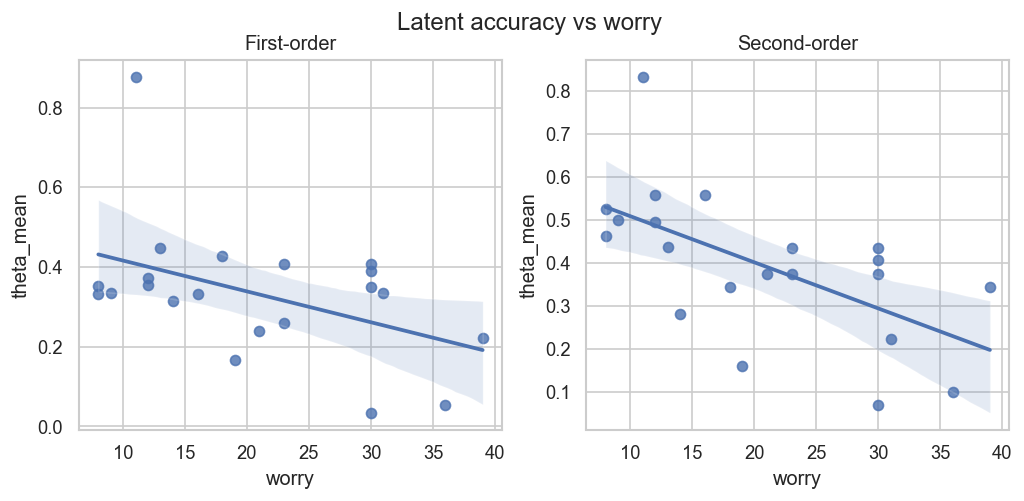

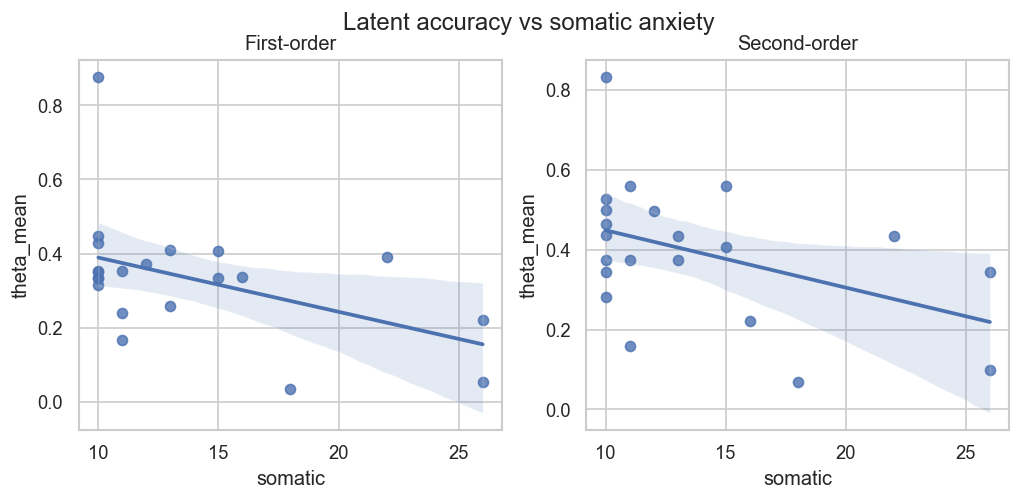

In [27]:
# Scatter of theta_mean vs anxiety facets
fig,ax=plt.subplots(1,2,figsize=(10,4))
sns.regplot(data=first,x='worry',y='theta_mean',ax=ax[0]); ax[0].set_title('First-order')
sns.regplot(data=second,x='worry',y='theta_mean',ax=ax[1]); ax[1].set_title('Second-order')
plt.suptitle('Latent accuracy vs worry'); plt.show()

fig,ax=plt.subplots(1,2,figsize=(10,4))
sns.regplot(data=first,x='somatic',y='theta_mean',ax=ax[0]); ax[0].set_title('First-order')
sns.regplot(data=second,x='somatic',y='theta_mean',ax=ax[1]); ax[1].set_title('Second-order')
plt.suptitle('Latent accuracy vs somatic anxiety'); plt.show()